# Recomendation of similar/complementary clothes

## Load libraries and trained models

In [138]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

In [139]:
def get_image_path_by_id(id):
    """
    Returns image_path correspondent to id (e.g. 220094021)
    """
    shared_folder_path = '/content/drive/MyDrive/ds_project_dataset/'
    id = str(id) 
    return shared_folder_path + 'images/' + '0'+id[:2]+'/0' + id + '.jpg'

In [140]:
from google.colab import drive
drive.mount('/content/drive')

shared_folder_path = '/content/drive/MyDrive/ds_project_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
# Load the trained model of feature recognitions
model = load_model('my_model.h5')

In [142]:
# Lists of the class labels
colour_lst = \
    ['colour_Beige', 'colour_Black', 'colour_Blue', 'colour_Brown',
       'colour_Green', 'colour_Grey', 'colour_Metal', 'colour_Mole',
       'colour_Orange', 'colour_Pink', 'colour_Purple', 'colour_Red',
       'colour_Turquoise', 'colour_White', 'colour_Yellow']

product_lst = \
    ['Bags', 'Garment Full body',
       'Garment Lower body', 'Garment Upper body',
       'Shoes', 'Socks & Tights', 'Underwear']

pattern_lst = \
    ['pattern_All over pattern', 'pattern_Application/3D', 'pattern_Argyle',
       'pattern_Chambray', 'pattern_Check', 'pattern_Colour blocking',
       'pattern_Contrast', 'pattern_Denim', 'pattern_Dot',
       'pattern_Embroidery', 'pattern_Front print',
       'pattern_Glittering/Metallic', 'pattern_Hologram', 'pattern_Jacquard',
       'pattern_Lace', 'pattern_Melange', 'pattern_Mesh', 'pattern_Metallic',
       'pattern_Mixed solid/pattern', 'pattern_Neps',
       'pattern_Placement print', 'pattern_Sequin', 'pattern_Slub',
       'pattern_Solid', 'pattern_Stripe', 'pattern_Transparent',
       'pattern_Treatment']

index_lst = \
    ['Divided', 'Ladieswear', 'Menswear']

class_labels_dict = {'colour': colour_lst,
                     'product': product_lst,
                     'pattern': pattern_lst,
                     'index': index_lst}

In [143]:
# Load model ResNet50 for embedding vectors calculation
resnet_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', pooling='avg')

In [144]:
# Load the cloth items from the database with correpondent features an embedding vectors
df = pd.read_parquet('embeddings_df1.parquet')

## Load picture of your cloth

In [145]:
# Load user image
user_image_path = 'samples/sample_dress.jpg'
user_image = cv2.imread(user_image_path)

## Recognize features from the image (Color, Type, Pattern, Index)

In [146]:
# Resize the image to 80x80
IMG_SIZE_FOR_RECOGNITION = 80
user_image_for_recognition = cv2.resize(user_image, (IMG_SIZE_FOR_RECOGNITION, IMG_SIZE_FOR_RECOGNITION))

In [147]:
# Get probabilities of the classes
color_pred, type_pred, pattern_pred, index_pred = model.predict(np.array([user_image_for_recognition]))

# Save the recognized features to the Dictionary
pred_imag_dict = {
                  'product_group_name': class_labels_dict['product'][np.argmax(type_pred)],
                  'index_group_name': class_labels_dict['index'][np.argmax(index_pred)]
                    }

1/1 [==============================] - 0s 267ms/step


## Get embedding vector of the image

In [148]:
# Resize the image to 224x224
IMG_SIZE_FOR_EMBEDDING = 224
user_image_for_embedding = cv2.resize(user_image, (IMG_SIZE_FOR_EMBEDDING, IMG_SIZE_FOR_EMBEDDING))

In [149]:
# Add an extra batch dimension to the image
user_image_for_embedding = np.expand_dims(user_image_for_embedding, axis=0)

# Pass the image through the ResNet50 model
features = resnet_model.predict(user_image_for_embedding)

# Extract the embedding from the output of the model
embeddings = features.squeeze()

# Add embedding to the dictionary
pred_imag_dict['embedding'] = embeddings

1/1 [==============================] - 2s 2s/step


## Recommend similar/complementary clothes

In [150]:
# Define database to look for similar items
subset_similar = df[(df['product_group_name'] == pred_imag_dict['product_group_name']) & (df['index_group_name'] == pred_imag_dict['index_group_name'])].copy()

# Define database to look for complementary items
subset_comp = df[(df['product_group_name'] != pred_imag_dict['product_group_name']) & (df['index_group_name'] == pred_imag_dict['index_group_name'])].copy()

### Similar clothes

In [151]:
# Caluclate similarity scores between user image and images from the database
similarity_scores = []
for array in subset_similar["embedding"]:
    array = array.reshape(1, -1)
    similarity = cosine_similarity(pred_imag_dict['embedding'].reshape(1, -1), array)
    similarity_scores.append(similarity[0][0])
subset_similar['score'] = similarity_scores

In [152]:
# Get TOP 10 similar products
reccs = subset_similar.sort_values(by='score', ascending=False)[1:11]
reccs['article_id']

335      220094021
332      220094018
328      220094010
864      299733001
327      220094001
8701     525335018
4342     482130002
20035    586796004
2941     442992006
8146     520364003
Name: article_id, dtype: int64

#### Show results

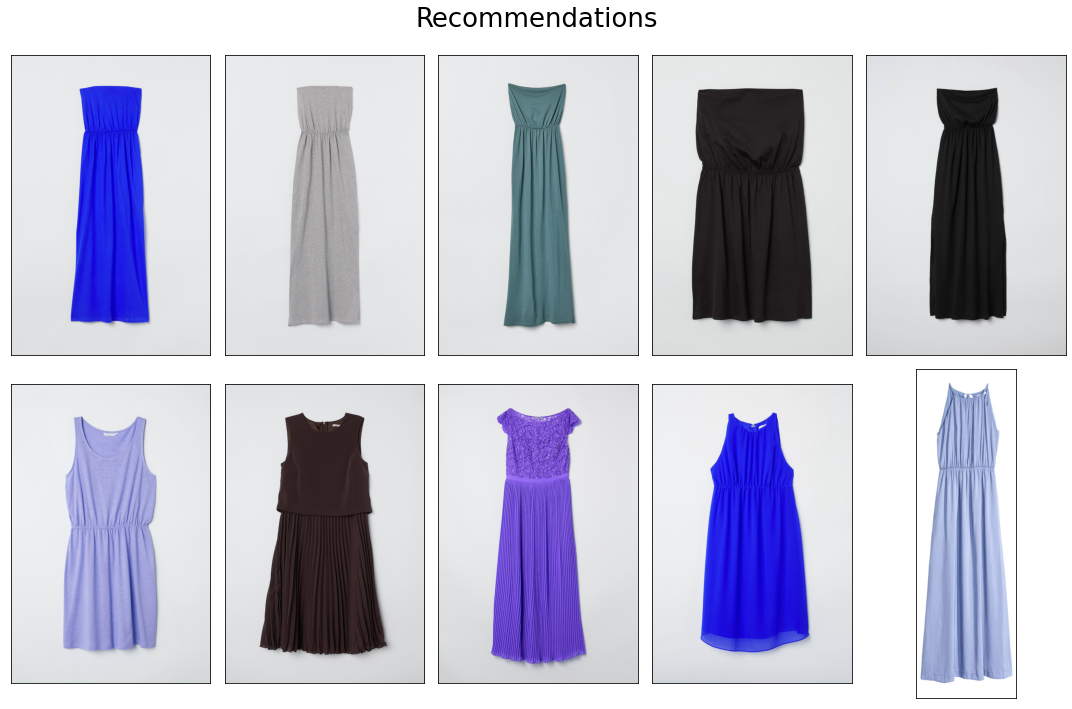

In [153]:
fig, ax = plt.subplots(2, 5, figsize=(3*5, 2*5))

for i, axis in zip(range(10), ax.flatten()):
  img = cv2.imread(get_image_path_by_id(id=reccs['article_id'].iloc[i]))
  axis.imshow(img)
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)
  #break
fig.suptitle("Recommendations", fontsize=26)
plt.tight_layout();

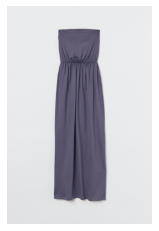

In [154]:
plt.imshow(user_image)
plt.axis('off')
plt.show();

### Complementary clothes

In [155]:
pred_imag_dict

{'product_group_name': 'Garment Full body',
 'index_group_name': 'Ladieswear',
 'embedding': array([0.7600951 , 0.00956843, 0.02503135, ..., 0.        , 0.11285957,
        0.14219953], dtype=float32)}

In [156]:
# Choose the same index_group_name. I.e. we recommend Ladieswear or Divided if the user has Ladieswear
subset_index = \
  subset_comp[(subset_comp['index_group_name'] == pred_imag_dict['index_group_name']) | \
              (subset_comp['index_group_name'] == 'Divided')]

In [157]:
# Choose which type of clothes to recommmend
types_to_recommend_lst = class_labels_dict['product'].copy()

if pred_imag_dict['product_group_name'] == 'Garment Full body':
  types_to_recommend_lst.remove('Garment Full body')
  types_to_recommend_lst.remove('Garment Lower body')
  types_to_recommend_lst.remove('Garment Upper body')
elif pred_imag_dict['product_group_name'] == 'Garment Lower body':
  types_to_recommend_lst.remove('Garment Full body')
  types_to_recommend_lst.remove('Garment Lower body')
elif pred_imag_dict['product_group_name'] == 'Garment Upper body':
  types_to_recommend_lst.remove('Garment Full body')
  types_to_recommend_lst.remove('Garment Upper body')

In [158]:
def get_most_similar_vectors(subset_comp, pred_imag_dict):
  # Caluclate similarity scores between user image and images from the database
  similarity_scores = []
  for array in subset_comp["embedding"]:
      array = array.reshape(1, -1)
      similarity = cosine_similarity(pred_imag_dict['embedding'].reshape(1, -1), array)
      similarity_scores.append(similarity[0][0])
  subset_comp['score'] = similarity_scores

  # Get TOP # similar products
  reccs = subset_comp.sort_values(by='score', ascending=False)[:3]
  return list(reccs['article_id'].values)

In [159]:
id_product_lst = []

for type_to_recommend in types_to_recommend_lst:
  subset_group = subset_index[subset_index['product_group_name'] == type_to_recommend]
  subset_group = subset_group.copy()
  if subset_group.shape[0] == 0:
    continue
  id_product_lst.append(get_most_similar_vectors(subset_group, pred_imag_dict))
  #break

In [160]:
# Flatten list of ID
id_product_lst = [item for sublist in id_product_lst for item in sublist]

#### Show results

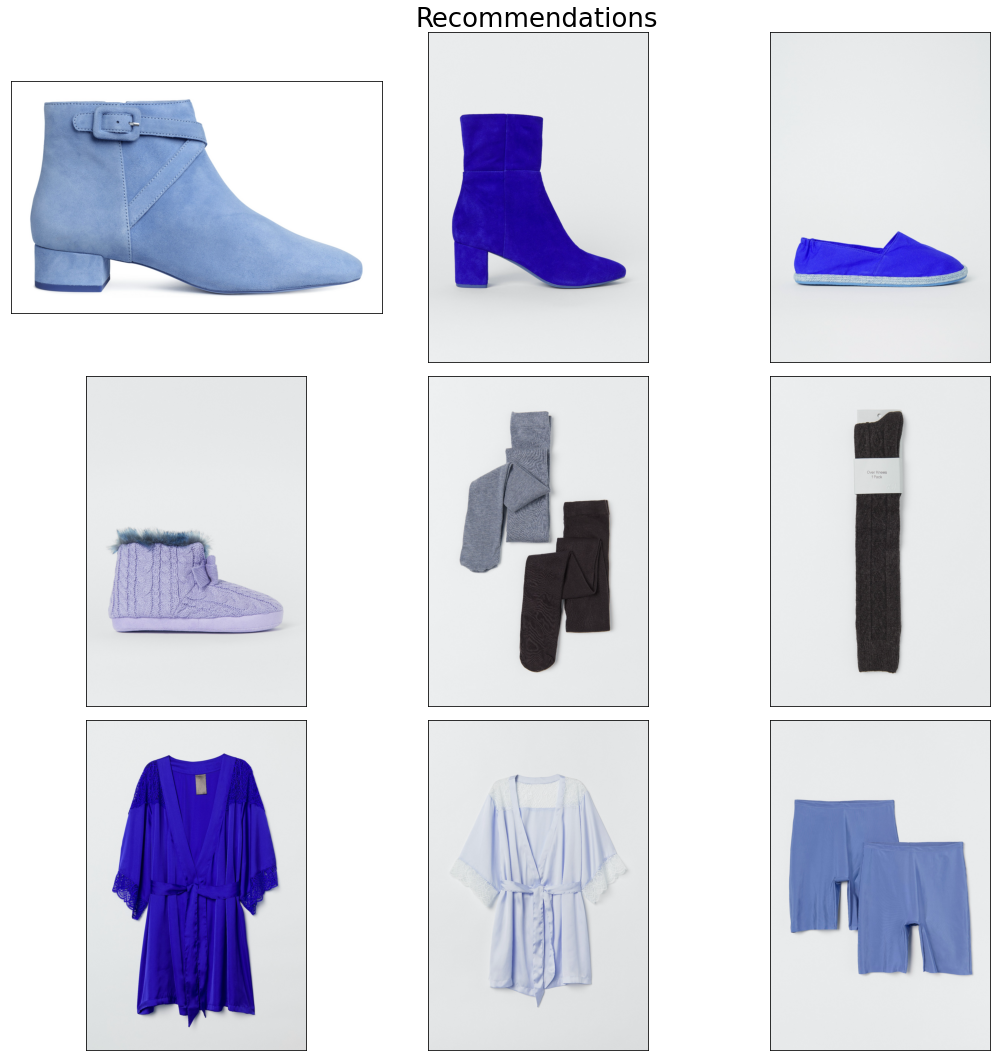

In [161]:
fig, ax = plt.subplots(3, 3, figsize=(3*5, 3*5))

for index, axis in zip(id_product_lst, ax.flatten()):
  img = cv2.imread(get_image_path_by_id(id=index))
  axis.imshow(img)
  axis.get_xaxis().set_visible(False)
  axis.get_yaxis().set_visible(False)
  #break
fig.suptitle("Recommendations", fontsize=26)
plt.tight_layout();

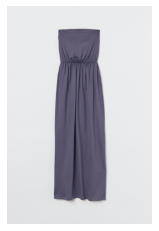

In [64]:
plt.imshow(user_image)
plt.axis('off')
plt.show();

In [133]:
#!git branch
# !git add .
# !git commit -m "final notebook for recommendation update"
# !git push origin kuzma


* kuzma
  main
  noa
  omri
